In [8]:
import os
from dotenv import load_dotenv
import snowflake.connector
import pandas as pd
import plotly.express as px
# Use Plotly's "make_subplots" function from "plotly.subplots" to layout elements horizontally
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Load credentials
load_dotenv()

True

In [9]:
# Connect to Snowflake
conn = snowflake.connector.connect(
    user=os.getenv('SNOWFLAKE_USER'),
    password=os.getenv('SNOWFLAKE_PASSWORD'),
    account=os.getenv('SNOWFLAKE_ACCOUNT') + '.' + os.getenv('SNOWFLAKE_REGION'),
    warehouse=os.getenv('SNOWFLAKE_WAREHOUSE'),
    database='WALMART_DB',
    schema='SILVER',
    role=os.getenv('SNOWFLAKE_ROLE')
)

In [10]:
# SQL query

sql = """
SELECT
    wft.CPI,
    wft.store_weekly_sales AS weekly_sales
FROM
    walmart_fact_table wft
"""

# Run the query using Snowflake connector.
cur = conn.cursor()
cur.execute(sql)

# Load results into DataFrame
columns = [col[0] for col in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data, columns=columns)

# Force the column names to lowercase for each dataframe
df.columns = [col.lower() for col in df.columns]

# print(df)


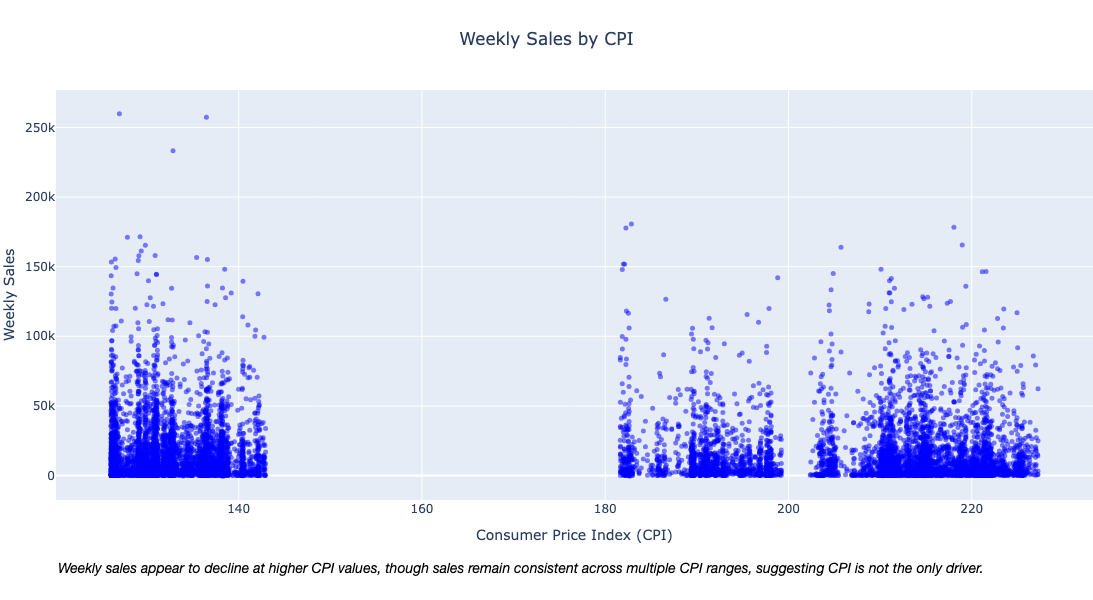

In [46]:
# Build the presentation.  With only a single graph here, we do NOT
# need to use subplots

# ==============================

# Formatting function
def formatSales(value):
    if value >= 1_000_000_000:
        return f"${value / 1_000_000_000:.2f}B"
    elif value >= 1_000_000:
        return f"${value / 1_000_000:.2f}M"
    elif value >= 1_000:
        return f"${value / 1_000:.2f}K"
    else:
        return f"${value:2f}"

# ===============================

# It's likely that our dataset will be too large for Plotly to be able to
# plot all the points.  This was evidenced with several lock-up events 
# while trying to run the report initially.
# Pull a sample subset of about 10K rows to do the analysis.  Include a
# "random_state" parameter to be able to reproduce the exact same sample
# with each successive run.
df_sampled = df.sample(n=10000, random_state=23)

# Weekly Sales by CPI
trace_sales_by_cpi = go.Scatter(
    x = df_sampled['cpi'],
    y = df_sampled['weekly_sales'],
    mode = 'markers',
    marker = dict(size=5, color='blue', opacity=0.5),
    hovertemplate='CPI: %{x:.2f}<br>Weekly Sales: %{y:$,.2f}<extra></extra>'
)

fig = go.Figure()

# Create a trace for the yearly bar chart
fig.add_trace(trace_sales_by_cpi)

# ================================

# Update layout
fig.update_layout(
    title='Weekly Sales by CPI',
    title_x = 0.5,
    xaxis_title = 'Consumer Price Index (CPI)',
    yaxis_title = 'Weekly Sales',
    margin=dict(l=0, r=0, t=90, b=100),  # reduce the left/right margin a bit to help with horizontal scrolling
    height=600,
    width=1075
    # showlegend = False
)

# Add an annotation to describe what we're seeing
fig.add_annotation(
    text = '<i>Weekly sales appear to decline at higher CPI values, though sales remain consistent across multiple CPI ranges, suggesting CPI is not the only driver.</i>',
    x = 0.0,  # roughly center of line chart
    y = -0.19,  # above the line chart
    xref = "paper",
    yref = "paper",
    yanchor = 'bottom',
    xanchor = 'left',
    showarrow = False,
    font = dict(size=14, family="Helvetica Neue", color="black")
)



# Let's make the report title pop a little more
# title_font = dict(size=20, family="Helvetica", color='black', weight='bold')
# fig.update_layout(title=dict(text='Weekly Sales by Year, Month, and Day', x=0.48, font=title_font))


fig.show()
    


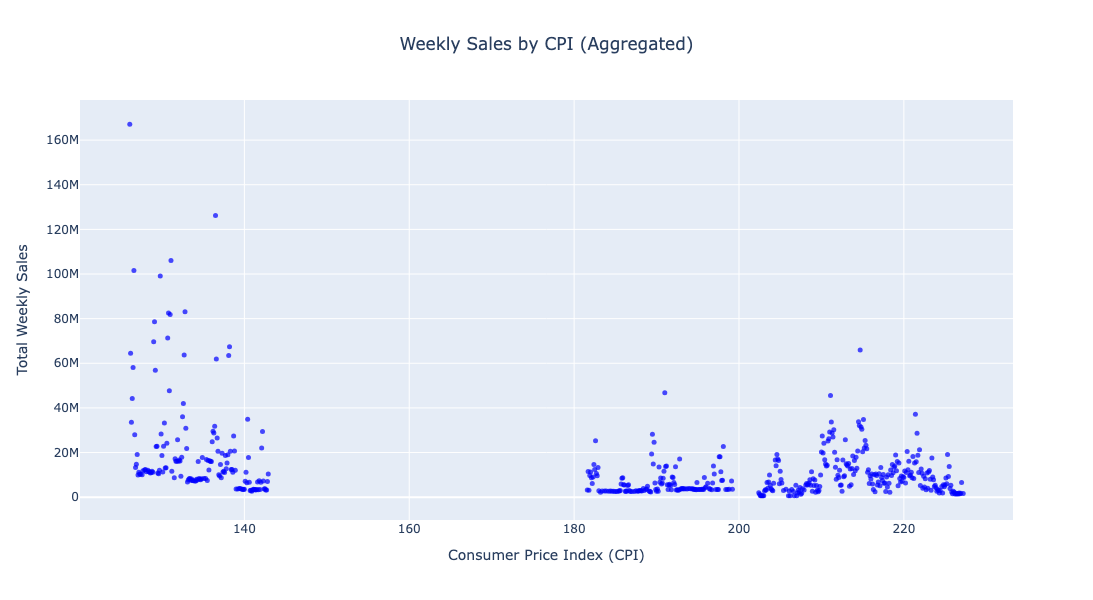

In [28]:
# Since my plot varied so much when compared to the plot in the project documentation,
# I decided to take a different approach to get closer to the image in the documentation.

# Round the CPI value down to a single decimal point to create "bins" for the CPI values
# Use the raw CPI data for this
df['cpi_bin'] = df['cpi'].round(1)

# Aggregate the weekly sales by the cpi bin
df_cpi_grouped = df.groupby('cpi_bin', as_index=False)['weekly_sales'].sum()

# Now recreate the scatter plot
# Weekly Sales by CPI
trace_sales_by_cpi_bin = go.Scatter(
    x = df_cpi_grouped['cpi_bin'],
    y = df_cpi_grouped['weekly_sales'],
    mode = 'markers',
    marker = dict(size=5, color='blue', opacity=0.7),
    hovertemplate='CPI: %{x:.1f}<br>Total Weekly Sales: %{y:$,.2f}<extra></extra>'
)

fig_by_bin = go.Figure()

# Create a trace for the yearly bar chart
fig_by_bin.add_trace(trace_sales_by_cpi_bin)

fig_by_bin.update_layout(
    title='Weekly Sales by CPI (Aggregated)',
    title_x = 0.5,
    xaxis_title='Consumer Price Index (CPI)',
    yaxis_title='Total Weekly Sales',
    height=600,
    width=1075
)

fig_by_bin.show()



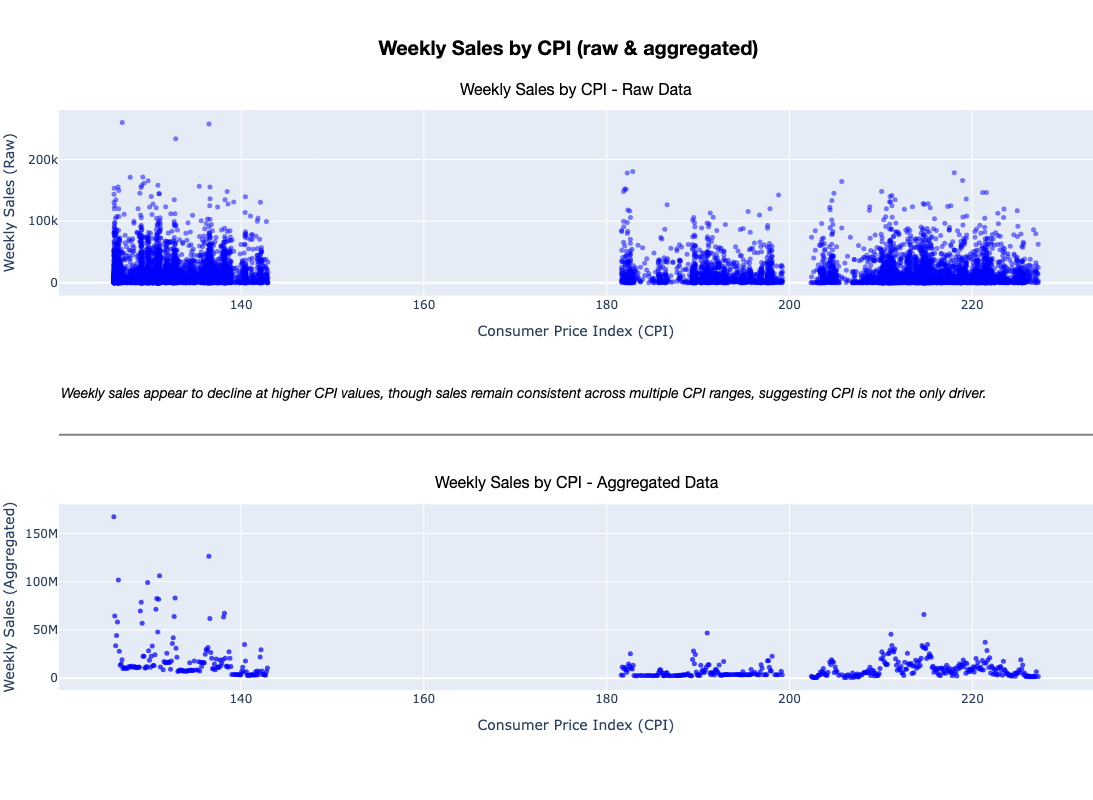

In [86]:
# Build the dashboard-type of presentation

# First, let's layout the overall container for the charts
fig = make_subplots(
    rows=2,
    cols=1,
    specs=[
        [{'type':"xy", 't':0, 'b':0}],
        [{"type":"xy", 't':0, 'b':0}]
    ],
    row_heights=[0.50, 0.50],
    vertical_spacing = 0.36,  # vertical spacing between the charts
)

# ===================================

# Raw Data 
# It's likely that our dataset will be too large for Plotly to be able to
# plot all the points.  This was evidenced with several lock-up events 
# while trying to run the report initially.
# Pull a sample subset of about 10K rows to do the analysis.  Include a
# "random_state" parameter to be able to reproduce the exact same sample
# with each successive run.
df_sampled = df.sample(n=10000, random_state=23)

# Weekly Sales by CPI
trace_sales_by_cpi = go.Scatter(
    x = df_sampled['cpi'],
    y = df_sampled['weekly_sales'],
    mode = 'markers',
    marker = dict(size=5, color='blue', opacity=0.5),
    hovertemplate='CPI: %{x:.2f}<br>Weekly Sales: %{y:$,.2f}<extra></extra>'
)

# Create a trace for the yearly bar chart
fig.add_trace(trace_sales_by_cpi, row=1, col=1)

# Add an annotation for the title of this Scatter plot
fig.add_annotation(
    text = 'Weekly Sales by CPI - Raw Data',
    x = 0.5,  # roughly center of line chart
    y = 1.055,  # above the line chart
    xref = "paper",
    yref = "paper",
    yanchor = 'top',
    xanchor = 'center',
    showarrow = False,
    font = dict(size=16, family="Helvetica Neue", color="black")
)

fig.update_xaxes(title_text="Consumer Price Index (CPI)", row=1, col=1)
fig.update_yaxes(title_text="Weekly Sales (Raw)", row=1, col=1)

# Add an annotation to describe what we're seeing
fig.add_annotation(
    text = '<i>Weekly sales appear to decline at higher CPI values, though sales remain consistent across multiple CPI ranges, suggesting CPI is not the only driver.</i>',
    x = 0.0,  # roughly center of line chart
    y = 0.53,  # above the line chart
    xref = "paper",
    yref = "paper",
    yanchor = 'top',
    xanchor = 'left',
    showarrow = False,
    font = dict(size=14, family="Helvetica Neue", color="black")
)

# =======================================

# Aggregated Data
# Since my plot varied so much when compared to the plot in the project documentation,
# I decided to take a different approach to get closer to the image in the documentation.

# Round the CPI value down to a single decimal point to create "bins" for the CPI values
# Use the raw CPI data for this
df['cpi_bin'] = df['cpi'].round(1)

# Aggregate the weekly sales by the cpi bin
df_cpi_grouped = df.groupby('cpi_bin', as_index=False)['weekly_sales'].sum()

# Now recreate the scatter plot
# Weekly Sales by CPI
trace_sales_by_cpi_bin = go.Scatter(
    x = df_cpi_grouped['cpi_bin'],
    y = df_cpi_grouped['weekly_sales'],
    mode = 'markers',
    marker = dict(size=5, color='blue', opacity=0.7),
    hovertemplate='CPI: %{x:.1f}<br>Total Weekly Sales: %{y:$,.2f}<extra></extra>'
)

# Create a trace for the yearly bar chart
fig.add_trace(trace_sales_by_cpi_bin, row=2, col=1)

# Add an annotation for the title of this Scatter plot
fig.add_annotation(
    text = 'Weekly Sales by CPI - Aggregated Data',
    x = 0.5,  # roughly center of line chart
    y = 0.34,  # above the line chart
    xref = "paper",
    yref = "paper",
    yanchor = 'bottom',
    xanchor = 'center',
    showarrow = False,
    font = dict(size=16, family="Helvetica Neue", color="black")
)

fig.update_xaxes(title_text="Consumer Price Index (CPI)", row=2, col=1)
fig.update_yaxes(title_text="Weekly Sales (Aggregated)", row=2, col=1)

# =======================================

fig.update_layout(
    margin=dict(l=0, r=0, t=110, b=110),
    title = {
        'text': '<b>Weekly Sales by CPI (raw & aggregated)</b>',
        'x': 0.52,
        'xanchor': 'center',
        'font': dict(
            size=20, 
            family="Helvetica Neue", 
            color="black"
        )    
    },
    # xaxis_title='Consumer Price Index (CPI)',
    # yaxis_title='Total Weekly Sales',
    height=800,
    width=1075,
    showlegend = False
)

# Horizontal, between earliest date and average temperature
fig.add_shape(
    type="line",
    x0=0, x1=1,
    y0=0.44, y1=0.44,
    xref="paper", yref="paper",
    line=dict(color="grey", width=2),
    layer="below"
)


fig.show()










In [49]:
# Close the connection
conn.close()